# **Near Field Scan Script for Aaron's Quickturn Antenna**

Tunes antenna using two Arduinos + two DAC boards

### Import modules

In [2]:
import sys
sys.path.append(r'C:\Users\User\Documents\Duke\Acquisition-Code\Modules')
import numpy as np
from matplotlib import pyplot as plt
# import VNA_control as vc
# import stage_control as sc
import probe_deconvolve as pd
import propagation_functions as pf
import scipy.constants
import scipy.io
import time
import datetime
# import mainPyDAC2_module_multiple_Aaron as tune
import pin_mappings as pm
import numpy.matlib

C     = scipy.constants.c
EPS_0 = scipy.constants.epsilon_0 #C^2/(N*m^2)
MU_0  = scipy.constants.mu_0    #m kg s^-2 A^-2
mm = 0.001
cm    = 0.01
GHz   = 1.0E9

### Serial initialization & tuning state generation

In [5]:
element_pin_index = pm.element_pin_index[:-1]

ts = []
for i in range(len(element_pin_index)):
    t = np.zeros(240)
    t[element_pin_index[i]] = 2.5
    ts.append(t)

160

### Test tuning state

In [12]:
# ts[10] = all 1V, ts[20] = all 2 V, ..., 
# ts[51]=1V element 1, ts[52]=1V element 2, ...,
# ts[212] = 2V element 1, ts[373] = 3V element 1, ...
# state = ts[51] 
# tune.testProgram30DAC(serial1, state)
# tune.testProgram30DAC(serial2, state)

### General scan parameters

In [6]:
a_probe = 22.86
b_probe = 10.16

xrange = 1000 # x length of stage, mm
yrange = 1000 # y length of stage, mm

fstart = 8E9
fstop = 12E9
NumFreqs = 101
NumApMasks = len(ts)
f = np.linspace(fstart, fstop, NumFreqs)
lam_min = C/fstop
dstep = lam_min/2 * 1000 # mm

IFBW = 1000
calfile = 'Aaron_21-11-05'
power = 0 # dBm
sParMeas = 'S12'
speedmms = 25       # don't change this

print('IFBW = {} \nCalibration File = {} \nPower = {} dBm \nMeasuring {}'.format(IFBW, calfile, power, sParMeas))

IFBW = 1000 
Calibration File = Aaron_21-11-05 
Power = 0 dBm 
Measuring S12


### Initialize instruments

In [11]:
## Stage
g = sc.stage_start('169.254.225.173')
sc.stage_home(g,speedmms)

## Arduino
numDACs = 30
serial1 = tune.initializeArduino(numDACs, "COM9")
serial2 = tune.initializeArduino(numDACs, "COM10")

## VNA
vna = vc.instrument_open('TCPIP0::169.254.187.153::5025::SOCKET')
vc.VNA_initiate(vna, NumFreqs, fstart*1E-9, fstop*1E-9, IFBW, power, 'S12', calfile=calfile)

Agilent Technologies,N5222A,MY51421573,A.09.90.10
Initiating VNA...

Done



### Configure save path

In [12]:
savename = 'Quickturn_Antenna'
savepath = 'C:/Users/smithlab/Documents/Near_Field_Scans/'

### Scan

#### *Set scan lengths*

In [36]:
Lx_ap = 300
Ly_ap = 190
theta = 30
d = 91

Lx_scan = Lx_ap + 2*d*np.tan(np.radians(theta))
Ly_scan = Ly_ap + 2*d*np.tan(np.radians(theta))

xmin = -Lx_scan/2
xmax = Lx_scan/2
ymin = -Ly_scan/2
ymax = Ly_scan/2

x_probe = np.arange(xmin, xmax, dstep)
y_probe = np.arange(ymin, ymax, dstep)
X_probe, Y_probe = np.meshgrid(x_probe, y_probe, indexing='xy')
measurements_x = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks), dtype=np.complex128) # measurements with E field of probe oriented in x direction
measurements_y = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks), dtype=np.complex128) # measurements with E field of probe oriented in y direction
stops = Y_probe.shape[0] * X_probe.shape[1]

#### *Move to new origin*

In [35]:
center_x = -xrange/2
center_y = -yrange/2
pos_x = -70  # adjust to change x zero position
pos_y = -40  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,0,0,center_x+pos_x,center_y+pos_y)

(-570.0, -540.0)

#### *Set origin*

In [37]:
defZeroInXsteps, defZeroInYsteps = sc.zero_axes(g)

#### *Start scan - x-polarization*

In [41]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

(-202.5388, -147.5388)

In [42]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        for jj in range(NumApMasks):
            tune.testProgram30DAC(serial1,ts[jj])
            tune.testProgram30DAC(serial2,ts[jj])
            time.sleep(0.01)
            measurements_x[yn,xn,:,jj] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


Est. time remaining: 264.366080376837 hours
Est. time remaining: 260.8819494374593 hours
Est. time remaining: 257.70610175728797 hours
Est. time remaining: 254.3028362083435 hours
Est. time remaining: 250.72567687047854 hours
Est. time remaining: 247.52542810440065 hours
Est. time remaining: 244.03205491728252 hours
Est. time remaining: 240.70514656384785 hours
Est. time remaining: 290.2772794890404 hours
Est. time remaining: 233.88282212813695 hours
Est. time remaining: 230.5647382010354 hours
Est. time remaining: 227.17949017206828 hours
Est. time remaining: 223.78171350214217 hours
Est. time remaining: 220.37652989943822 hours
Est. time remaining: 217.15201695521674 hours
Est. time remaining: 213.70576059977213 hours
Est. time remaining: 210.20564261542427 hours
Est. time remaining: 206.85119729280473 hours
Est. time remaining: 203.45006727602745 hours
Est. time remaining: 200.09459631707932 hours
Est. time remaining: 196.75459582448005 hours
Est. time remaining: 193.43364347245958 

#### *Start scan - y-polarization*

In [ ]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X_probe[0,0],Y_probe[0,0]) # move to start position

In [40]:
t = time.time()
stopscomp = 0

x_list = []
y_list = []
for yn in range(Y_probe.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X_probe.shape[1])
    else:
        xindex = np.flip(np.arange(X_probe.shape[1]))
        
    for xn in xindex:
        x = X_probe[yn, xn]
        y = Y_probe[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        for jj in range(NumApMasks):
            tune.testProgram30DAC(serial1,ts[jj])
            tune.testProgram30DAC(serial2,ts[jj])
            time.sleep(0.01)
            measurements_y[yn,xn,:,jj] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


Est. time remaining: 264.4011574104097 hours
Est. time remaining: 261.0154204874569 hours
Est. time remaining: 257.6186923336983 hours
Est. time remaining: 254.1380053869883 hours
Est. time remaining: 250.81464299586085 hours
Est. time remaining: 247.40609361410142 hours


KeyboardInterrupt: 

#### *Concatenate measurements*

In [44]:
measurements = np.stack((measurements_x, measurements_y), axis=4)

### Probe compensation

In [46]:
# measurements_corrected = np.zeros((Y_probe.shape[0], X_probe.shape[1], NumFreqs, NumApMasks, 2), dtype=np.complex128)

# for i in range(NumFreqs):

#     A_mat = pd.make_A_mat(f[i], a_probe*mm, b_probe*mm, x_probe*mm, y_probe*mm, d*mm)

#     for j in range(NumApMasks):

#         measurements_corrected[:,:,i,j,:] = np.transpose(pd.probe_deconvolve(np.transpose(measurements[:,:,i,j,:], (1,0,2)), A_mat, x_probe*mm, y_probe*mm), (1,0,2))
        
measurements_corrected = measurements    # TEMP, UNTIL PROBE CORRECTION IS SOLVED
    

### Plot

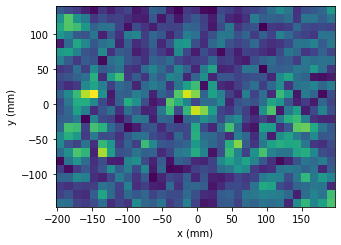

In [62]:
f_indx = np.argmin(np.abs(f - 10E9))
m_indx = 0

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
ax1.imshow(np.abs(measurements[:,:,51,300,0]), extent=(np.min(x_probe), np.max(x_probe), np.min(y_probe), np.max(y_probe)))
ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')
plt.show()


### Save data

In [48]:
scipy.io.savemat('{}{}_{}.mat'.format(savepath, savename, datetime.datetime.now().strftime('%Y-%m-%d')),
                                      {'X': X_probe,
                                       'Y': Y_probe,
                                       'Lx_ap': Lx_ap,
                                       'Ly_ap': Ly_ap,
                                       'f': f,
                                       'ts': ts,
                                       'measurements': measurements,
                                       'measurements_corrected': measurements_corrected})

In [49]:
measurements.shape

(24, 33, 101, 856, 2)

In [51]:
len(ts)

856